<a href="https://colab.research.google.com/github/Naomi2022/Naomi2022/blob/main/Basic_Augmentations_Typing_Trial1_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import os
from matplotlib import image
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf


##Loading and Preparing Data


###Load Data

In [3]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
FOLDER_PATH = 'Trial1'
ROOT_PATH = '/content/drive/MyDrive/Technion'
PATH = os.path.join(ROOT_PATH, FOLDER_PATH)
all_files = os.listdir(PATH)
all_files = np.array(all_files)
#remove the files that are duplicates
duplicates = np.where([(')'in i) for i in all_files])
all_files = np.delete(all_files, duplicates)
print(len(all_files))
#print(all_files[-20:-1])

2000


In [5]:
sample_size = 200
img_size = 480
data = np.zeros((sample_size, img_size, img_size)) #array to store pixeled images in
labels = np.empty((sample_size), dtype = str)

for i, file in enumerate(all_files[0:sample_size]):
    if i % 100 == 0:
      print(i)
    labels[i] = file[-5]
    if labels[i] == '':
      print(file)
    filename = os.path.join(PATH, file)
    gray_img = image.imread(filename)
    if gray_img.shape == (): #check that all files contain images that are properly loaded
        print("{} is an empty file".format(filename))
        #for now this column in data will stay all 0s, can do something later to delete it
    else:
      cropped_gray_img = np.array([i[150:630] for i in gray_img])
      data[i] = cropped_gray_img   
    #print('Gray shape:', gray_img.shape)
    #print('img.dtype: ', gray_img.dtype)
    #print('img.size: ', gray_img.size)

0
100


data shape:  (200, 480, 480)


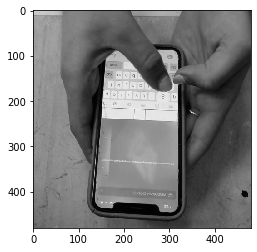

s
[0.82352942 0.81960785 0.81960785 0.81568629 0.81568629 0.81960785
 0.81960785 0.82352942 0.82352942 0.82352942]


In [6]:
#check the data was loaded correctly
print('data shape: ', data.shape)  
plt.imshow(data[2], interpolation='nearest', cmap='gray', vmin=0, vmax=1) #show images in gray
plt.show()
print(labels[2])
print(data[2][1][0:10])

In [72]:
labels.shape

(2000,)

2000


<function matplotlib.pyplot.show>

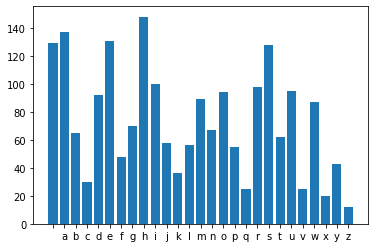

In [75]:
#plot bar plots of label frequencies
import pandas as pd
labels_df = pd.Series(list(labels), dtype="category")
letters = list(np.unique(labels))
counts = labels_df.value_counts(sort=False)
print(sum(counts))
plt.bar(letters, counts)
plt.show

###Do Augmentations

In [ ]:
from PIL import Image, ImageDraw

In [61]:
### Augment slight warps ###

from skimage import data as dt
from skimage import transform


def aug_warp(image, image_size):
  #img = dt.image()
  src = np.array([[0, 0], [0, image_size], [image_size, image_size], [image_size, 0]])
  factor1 = np.random.randint(50)
  factor2 = np.random.randint(50)
  #front back warp
  #bring top closer
  dst1 = np.array([[0 + factor1, 0], [0, image_size], [image_size, image_size], [image_size-factor1, 0]])
  #bring bottom closer
  dst2 = np.array([[0, 0], [0+factor1, image_size], [image_size-factor1, image_size], [image_size, 0]])

  #side to side warp
  #bring left closer
  dst3 = np.array([[0, 0+factor2], [0, image_size-factor2], [image_size, image_size], [image_size, 0]])
  #bring right closer
  dst4 = np.array([[0, 0], [0, image_size], [image_size, image_size-factor2], [image_size, 0+factor2]])

  tform3 = transform.ProjectiveTransform()
  tform3.estimate(src, (dst1 if np.random.rand() >= 0.5 else dst2) )
  warp_img = transform.warp(image, tform3, output_shape=(image_size, image_size))
  tform3.estimate(src, (dst3 if np.random.rand() >= 0.5 else dst4) )
  warp_img = transform.warp(warp_img, tform3, output_shape=(image_size, image_size))

  return np.array(warp_img)

def print_aug_warp():
  for img in data[0:10]:
    new_img = aug_warp(img, 480)
    plt.imshow(new_img, interpolation='nearest', cmap='gray', vmin=0, vmax=1) #show images in gray
    plt.show()

#print_aug_warp()


In [62]:
### Augment slight rotations ###
#Input: Square Photo
#Output: square photo of same size rotated 45 to -45 degrees

from skimage.transform import rotate

def aug_rotate(image):
  #add slight rotation between 315 and 45
  deg = np.random.randint(-10, 10)
  aug_img = rotate(image, deg)
  return aug_img

def print_aug_rotate():
  for img in data[0:10]:
    new_img = aug_rotate(img)
    plt.imshow(new_img, interpolation='nearest', cmap='gray', vmin=0, vmax=1) #show images in gray
    plt.show()

#print_aug_rotate()

In [63]:
from PIL import Image, ImageDraw
### Augment zoom ins ###
#input a square image
def aug_crop(image, resize_shape):
  img = Image.fromarray(image)
  x1 = np.random.randint(0, 50)
  y1 = np.random.randint(0, 50)
  x2 = np.random.randint(0, 50)
  y2 = (x1+x2) - y1
  smallest_box = (125, 55, 360, 290)   #biggest_box = (75, 0, 400, 330)
  box = (135-x1, 65-y1, 335+x2, 265+y2)
  crop_img = img.crop(box)
  #print(crop_img.size)
  resize_img = crop_img.resize((resize_shape, resize_shape))
  return np.array(resize_img)

def print_aug_crop():
  for img in data[np.arange(0, sample_size, 21)]:
    new_img = aug_warp(img, 480)
    new_img = aug_rotate(new_img)
    new_img = aug_crop(new_img, 224)
    print(new_img.shape)
    plt.figure(figsize=(2,2))
    plt.imshow(new_img, interpolation='nearest', cmap='gray', vmin=0, vmax=1) #show images in gray
    plt.show()

#print_aug_crop()

In [64]:
### Augment brightness ###
def aug_bright(image):
    factor = np.random.randint(-13, 18)/100 
    aug_img = np.squeeze(np.array([[i + factor] for i in image]))
    return aug_img

def print_aug_bright():
  for img in data[0:5]:
    new_img = aug_bright(img)
    plt.imshow(new_img, interpolation='nearest', cmap='gray', vmin=0, vmax=1) #show images in gray
    plt.show()

#print_aug_bright()

In [65]:
#I also want an augmentation for different zoom ins
img_size = 224 #change the image size to the new image size you want
num_augs = 1
sample_size = 200
aug_data = np.zeros((sample_size*num_augs, img_size, img_size))
for i,img in enumerate(data[0:sample_size]):
  
    new_img = aug_warp(img, 480)
    new_img = aug_rotate(new_img)
    new_img = aug_crop(new_img, 224)
    new_img = aug_bright(new_img)
    
    #add image to the new data set
    aug_data[i] = new_img

#now we use aug_data in our model

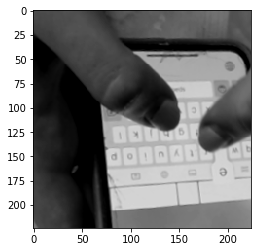

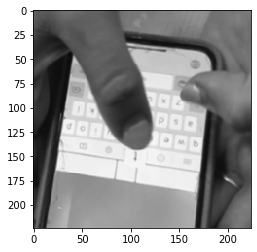

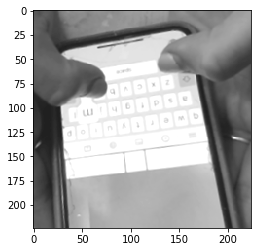

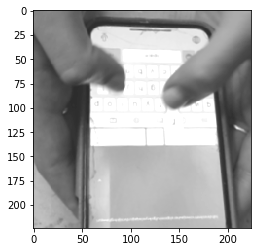

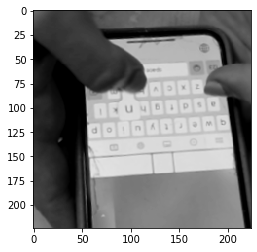

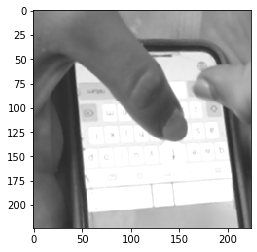

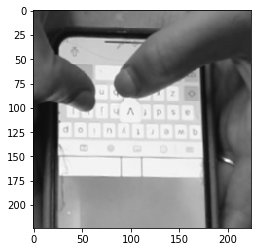

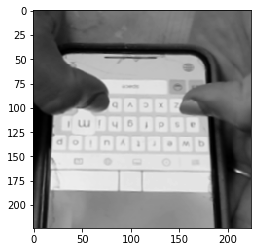

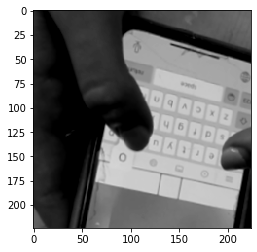

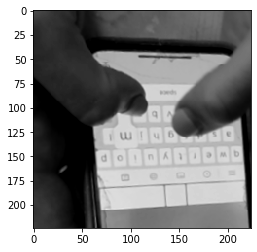

In [67]:
def print_aug_data():
  for img in aug_data[np.arange(0, sample_size, 21)]:
    plt.imshow(img, interpolation='nearest', cmap='gray', vmin=0, vmax=1) #show images in gray
    plt.show()

print_aug_data()

In [ ]:
for i in np.array([55, 667, 1783, 1843, 3058, 3960, 2848, 2865]):
  plt.imshow(aug_data[i], interpolation='nearest', cmap='gray', vmin=0, vmax=1) #show images in gray #interpolation='nearest', , vmin=0, vmax=1
  plt.show()

NameError: ignored

In [ ]:
#create our augmented labels by stacking 3 in a row
aug_labels = np.concatenate((labels, labels))
aug_labels.shape
print(aug_labels[np.arange(0, sample_size*num_augs, 1000)])

['e' 'r' 'e' 'r']


In [ ]:
del data
del labels

0


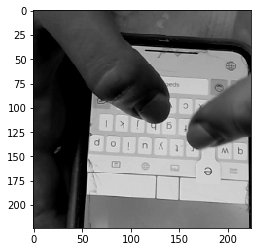

e
1000


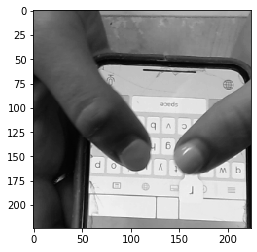

r
2000


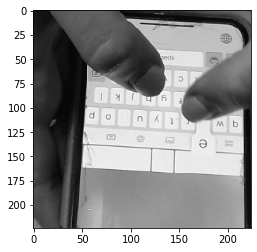

e
3000


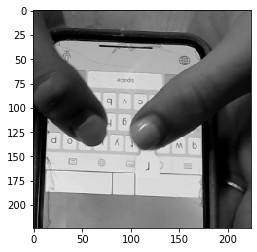

r


In [ ]:
for i in np.arange(0, 4000, 1000):
  print(i)
  plt.imshow(aug_data[i], interpolation='nearest', cmap='gray', vmin=0, vmax=1) #show images in gray
  plt.show()
  print(aug_labels[i])

###Find phone in image

In [ ]:
#detect phone in image
import argparse
import cv2


#pick classes to box and box colors
CLASSES = ["background", "cell phone", "keyboard"]
COLORS = (np.random.uniform(0, 255, size=(len(CLASSES), 3)))
COLORS = COLORS.astype('int')
print(COLORS)


# load our serialized model from disk
print("[INFO] loading model...")
net = cv2.dnn.readNetFromCaffe('/content/drive/MyDrive/Technion/MobileNetSSD_deploy.prototxt.txt', '/content/drive/MyDrive/Technion/MobileNetSSD_deploy.caffemodel')

# load the input image and construct an input blob for the image
# by resizing to a fixed 300x300 pixels and then normalizing it
# (note: normalization is done via the authors of the MobileNet SSD
# implementation)
#image = cv2.imread(args["image"])

#if the authors normalize for an color image, but i normalize for a black and white image will it be  differernt.. no
img = np.array([[np.round(i * 255)for i in row] for row in data[1]])

print(img.shape)
print(img)
img = img[..., np.newaxis]
img = tf.image.grayscale_to_rgb(tf.constant(img))
img = img.numpy()
#print(cv2.resize(img, (300, 300)).shape)
#print(cv2.resize(data[1], (300, 300)).shape)
img = img.astype('float32')
#now img is a (480, 480, 3) array of normalized grayscalre image values


#(h, w) = img.shape[:2]
#blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1, (300, 300))



#create a blob object for image recognition

scale = 0.017
#mirror: false    
crop_size = (224,224)
mean_value = [103.94,116.78,123.68]


#blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300))
blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), scale, (300, 300), 127.5)





# pass the blob through the network and obtain the detections and
# predictions
print("[INFO] computing object detections...")
net.setInput(blob)

detections = net.forward()

print(detections.shape) #2:probability for each item found #3:2 are the probabilities for that item, 3-7 are the four bounding boxes of the image)
print('DETECTIONS 0')
print(detections[0][0][0:10])

# loop over the detections

'''
for i in np.arange(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with the
	# prediction
	confidence = detections[0, 0, i, 2]
	# filter out weak detections by ensuring the `confidence` is
	# greater than the minimum confidence
  
  if confidence > 0.2:
		# extract the index of the class label from the `detections`,
		# then compute the (x, y)-coordinates of the bounding box for
		# the object
		idx = int(detections[0, 0, i, 1]) - 1
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# display the prediction
		label = "{}: {:.2f}%".format(CLASSES[1], confidence * 100) #idx
		print("[INFO] {}".format(label))
		#cv2.rectangle(img, (startX, startY), (endX, endY), COLORS , 2) #idx ,COLORS[2], 2
		y = startY - 15 if startY - 15 > 15 else startY + 15
		#cv2.putText(img, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[1], 2) #idx
  
# show the output image
plt.imshow(img, interpolation='nearest', cmap='gray', vmin=0, vmax=1) #show images in gray #interpolation='nearest', , vmin=0, vmax=1
plt.show()
#v2.imshow("Output", image)
#cv2.waitKey(0)
'''
'''
#call
python deep_learning_object_detection.py \
	--prototxt MobileNetSSD_deploy.prototxt.txt \
	--model MobileNetSSD_deploy.caffemodel --image images/example_01.jpg 
'''


[[ 40  13  89]
 [203 224 246]
 [ 62  96 249]]
[INFO] loading model...
(480, 480)
[[210. 209. 208. ...  38.  38.  38.]
 [209. 208. 208. ...  38.  38.  39.]
 [208. 208. 208. ...  38.  38.  41.]
 ...
 [105. 104. 101. ... 102. 104. 107.]
 [104. 103. 101. ... 101. 104. 105.]
 [101. 100. 100. ... 100. 105. 102.]]
[INFO] computing object detections...
(1, 1, 100, 7)
DETECTIONS 0
[[0.00000000e+00 1.50000000e+01 7.68269479e-01 3.42908502e-02
  1.02776885e-02 9.55222726e-01 9.86635149e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e

'\n#call\npython deep_learning_object_detection.py \t--prototxt MobileNetSSD_deploy.prototxt.txt \t--model MobileNetSSD_deploy.caffemodel --image images/example_01.jpg \n'

In [ ]:
output = detections.squeeze()


In [ ]:
output[: , 2]

array([0.7682695, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 

In [ ]:
sorted = np.argsort(-output)[: , 2]
print(sorted)
print(output[sorted])

[844 487 590 798 626 810 674 893 743 419]
[0.65993893 0.08631471 0.06418508 0.02722527 0.02138806 0.01098513
 0.00847725 0.0071203  0.00679895 0.00594309]


In [ ]:
detections.shape #2:probability for each item found #3:2 are the probabilities for that item, 3-7 are the four bounding boxes of the image)
print('DETECTIONS 0')
print(detections[0][0])
np.arange(0, detections.shape[2])

DETECTIONS 0
[[0.0000000e+00 1.5000000e+01 8.4334826e-01 1.2192425e-01 1.1471510e-03
  8.8420403e-01 9.8033339e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

(480, 480, 3)
(1, 3, 200, 200)
(600, 200, 1)


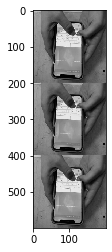

In [ ]:
print(img.shape)
blob = cv2.dnn.blobFromImage(img, 1.0, (200, 200))
blobb = blob.reshape(blob.shape[2] * blob.shape[1], blob.shape[3], 1) 
print(blob.shape)
print(blobb.shape)
blobb = np.squeeze(blobb)
plt.imshow(blobb, interpolation='nearest', cmap='gray', vmin=0, vmax=1) #show images in gray #interpolation='nearest', , vmin=0, vmax=1
plt.show()



###Labels to one hot


In [ ]:
#now we have turn the labels into one hot encoding
classes = np.unique(aug_labels)
nClasses = len(classes)

#check the labels
print(np.unique(aug_labels))

#reshape the data to fit into the model
aug_data = aug_data.reshape(-1, img_size, img_size, 1)

#convert data to float32 and resale from 0-1
aug_data = aug_data.astype('float32')
#data = data / 225 #with matplot lib its already normalized
    

[' ' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q'
 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [ ]:
ord('a')

97

In [ ]:
#turn the characters into unique numbers
base = ord('a')
labels_int = np.array([ord(i) - base for i in aug_labels])
spaces = np.where([i == -65 for i in labels_int]) #make spaces equal to number 26
labels_int[spaces] = 26
labels_int = labels_int.astype('float32')
print(np.unique(labels_int))
#print(labels_int.dtype)


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26.]


In [ ]:
#change labels from categorical to one-hot encoding vectors
labels_onehot = to_categorical(labels_int, num_classes=nClasses)
print(labels_onehot[0:3])
labels_onehot.shape


[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0.]]


(4000, 27)

In [ ]:
#maybe we should do label augmentation here:
#now augment the labels - stack them 3 times

###Train Test Split

In [ ]:
#now we have our data and lables that we can split into train and test
#split the data into train, test and validation
seed = 6
X_tv, X_test, Y_tv, Y_test = train_test_split(aug_data, labels_onehot, test_size=0.20, random_state=seed)
X_train, X_val, Y_train, Y_val = train_test_split(X_tv, Y_tv, test_size = 0.20, random_state=seed)
print("X_train size: {}, Y_train size: {}, X_val size: {}, Y_vale size: {}, X_test size: {}, Y_test size: {}".format(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape))

X_train size: (2560, 224, 224, 1), Y_train size: (2560, 27), X_val size: (640, 224, 224, 1), Y_vale size: (640, 27), X_test size: (800, 224, 224, 1), Y_test size: (800, 27)


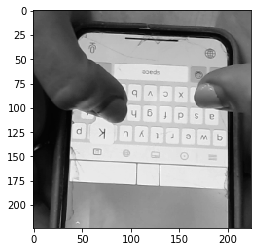

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


In [ ]:
#check that the picutes are stored correctly
plt.imshow((X_test[1].squeeze()), interpolation='nearest', cmap='gray', vmin=0, vmax=1) #show images in gray
plt.show()
print(Y_test[1])

##CNNs

In [ ]:
#import libraries for the network
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU


In [ ]:
#build the cnn model
batch_size = 32 #32 #64
epochs = 20
num_classes = nClasses

###prep for built in models

In [ ]:
X_train.shape

(2560, 224, 224, 1)

In [ ]:
#convert the gray image into a rgb format to be used by resnet
train_size = X_train.shape[0]
val_size = X_val.shape[0]
test_size = X_test.shape[0]
rgb_X_train=np.zeros((train_size, img_size, img_size, 3))
rgb_X_val=np.zeros((val_size, img_size, img_size, 3))
rgb_X_test=np.zeros((test_size, img_size, img_size, 3))

for i in range(train_size):
  rgb_X_train[i] = tf.image.grayscale_to_rgb(tf.constant(X_train[i]))
for i in range(val_size):
  rgb_X_val[i] = tf.image.grayscale_to_rgb(tf.constant(X_val[i]))
for i in range(test_size):
  rgb_X_test[i] = tf.image.grayscale_to_rgb(tf.constant(X_test[i]))

In [ ]:
print(rgb_X_train.shape)
print(rgb_X_train[0][50][0])
print(rgb_X_val.shape)
print(rgb_X_val[0][50][0])
print(rgb_X_test.shape)
print(rgb_X_test[0][50][0])

(2560, 224, 224, 3)
[0.34666669 0.34666669 0.34666669]
(640, 224, 224, 3)
[0.04117648 0.04117648 0.04117648]
(800, 224, 224, 3)
[0.18921569 0.18921569 0.18921569]


In [ ]:
del aug_data
del aug_labels


In [ ]:
del X_train
del X_test
del X_val
del X_tv

In [ ]:
del all_files
del aug_img
del cropped_gray_img
del file
del filename
del gray_img
del i
del image
del img
del img_size
del j
del labels_int
del x
del y
del train_size
del train_test_split

In [ ]:
dir()

###VGG16

In [ ]:
#vgg16 model
vgg16_model = Sequential()

pretrained_model_vgg16 = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=nClasses,
    classifier_activation='softmax'
)

for layer in pretrained_model_vgg16.layers:
  layer.trainable=False

vgg16_model.add(pretrained_model_vgg16)

vgg16_model.add(Conv2D(32, (3, 3), activation='linear',padding='same'))
vgg16_model.add(LeakyReLU(alpha=0.1))                  
vgg16_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
vgg16_model.add(Dropout(0.40))

vgg16_model.add(Flatten())
vgg16_model.add(Dense(64, activation='linear'))
vgg16_model.add(LeakyReLU(alpha=0.1))                  
vgg16_model.add(Dense(num_classes, activation='softmax'))

vgg16_model.compile(optimizer=keras.optimizers.Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])
vgg16_train1 = vgg16_model.fit(rgb_X_train, Y_train, batch_size=64,epochs=35,verbose=1,validation_data=(rgb_X_val, Y_val))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/35
40/40 [==============================] - 77s 437ms/step - loss: 3.2262 - accuracy: 0.0799 - val_loss: 2.7512 - val_accuracy: 0.2469
Epoch 2/35
40/40 [==============================] - 14s 357ms/step - loss: 2.5604 - accuracy: 0.2505 - val_loss: 1.8937 - val_accuracy: 0.4469
Epoch 3/35
40/40 [==============================] - 16s 410ms/step - loss: 1.7452 - accuracy: 0.4653 - val_loss: 1.2155 - val_accuracy: 0.6641
Epoch 4/35
40/40 [==============================] - 16s 404ms/step - loss: 1.1417 - accuracy: 0.6399 - val_loss: 0.8617 - val_accuracy: 0.7297
Epoch 5/35
40/40 [==============================] - 16s 403ms/step - loss: 0.8147 - accuracy: 0.7393 - val_loss: 0.6412 - val_accuracy: 0.8031
Epoch 6/35
40/40 [==============================] - 16s 408ms/step - loss: 0.6119 - accuracy: 0.8060 - val_loss: 0.5179 - val_accuracy: 0.8391
Epoch 7/35
40/40 [==============================] - 14s 352ms/step - loss: 0.4523 - accuracy: 0.8679 - val_loss: 0.4812 - val_accuracy: 0.8531

####Make predictions from model

In [ ]:
predicted_classes_vgg = vgg16_model.predict(rgb_X_test)
predicted_class_vgg = np.argmax(np.round(predicted_classes_vgg),axis=1)

In [ ]:
results = predicted_class_vgg == [np.argmax(i) for i in Y_test]
print('{} / {} were correctly classified, {}%'.format(sum(results), len(results), sum(results)*100/ len(results) ))
#[chr(i + 65) for i in np.array(predicted_classes_vgg)]
#correct_vgg = np.where(predicted_classes_vgg==Y_test)[0]
#print("Found %d correct labels".format(len(correct_vgg)))

757 / 800 were correctly classified, 94.625%


In [ ]:
#change to x test rgb
plt.imshow((X_test[1].squeeze()), interpolation='nearest', cmap='gray', vmin=0, vmax=1) #show images in gray
plt.show()
print(Y_test[1])

In [ ]:
prob = vgg16_model.predict_proba(rgb_X_test, batch_size=1, verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [ ]:
print(prob.shape)
print(prob[0])
print(Y_test[0])
print(np.argmax(prob[0]))

(100, 27)
[3.2418713e-05 1.3667786e-05 1.0512868e-07 7.9152346e-10 1.3118791e-06
 3.8877603e-09 3.8949065e-06 7.3301442e-07 2.5704093e-04 8.7569521e-07
 3.6666544e-05 2.4707446e-05 1.5416475e-08 5.8103431e-08 9.9367452e-01
 5.9187617e-03 1.5157268e-05 3.5358818e-07 4.6607943e-07 2.5777845e-07
 1.0290455e-05 9.3480503e-09 2.8525787e-06 1.2167647e-08 5.4129232e-06
 2.9074041e-08 4.7619534e-07]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
14


In [ ]:

print(predicted_classes_vgg.shape)
print(predicted_classes_vgg[0])
print(Y_test[0])
print(np.argmax(predicted_classes_vgg[0]))

(100, 27)
[3.24185930e-05 1.36675508e-05 1.05127270e-07 7.91502308e-10
 1.31185277e-06 3.88769372e-09 3.89486195e-06 7.33006743e-07
 2.57037493e-04 8.75681792e-07 3.66663371e-05 2.47069984e-05
 1.54162692e-08 5.81023230e-08 9.93674517e-01 5.91867696e-03
 1.51572385e-05 3.53584142e-07 4.66072777e-07 2.57775525e-07
 1.02902486e-05 9.34790823e-09 2.85254896e-06 1.21674857e-08
 5.41285135e-06 2.90736519e-08 4.76185335e-07]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
14


In [ ]:
total = sum(predicted_classes_vgg[5])
total


0.9999999511846909

In [ ]:
def predict_letter(formatted_image): #immage is a (1, 224, 224, 3) array or normalized pixels 3 times repeted black and white
    prediction = vgg16_model.predict(formatted_image)
    prediction = np.argmax(np.round(prediction),axis=1)
    return(chr(prediction+96))

####plot results through time

(100, 27)
(27, 100)


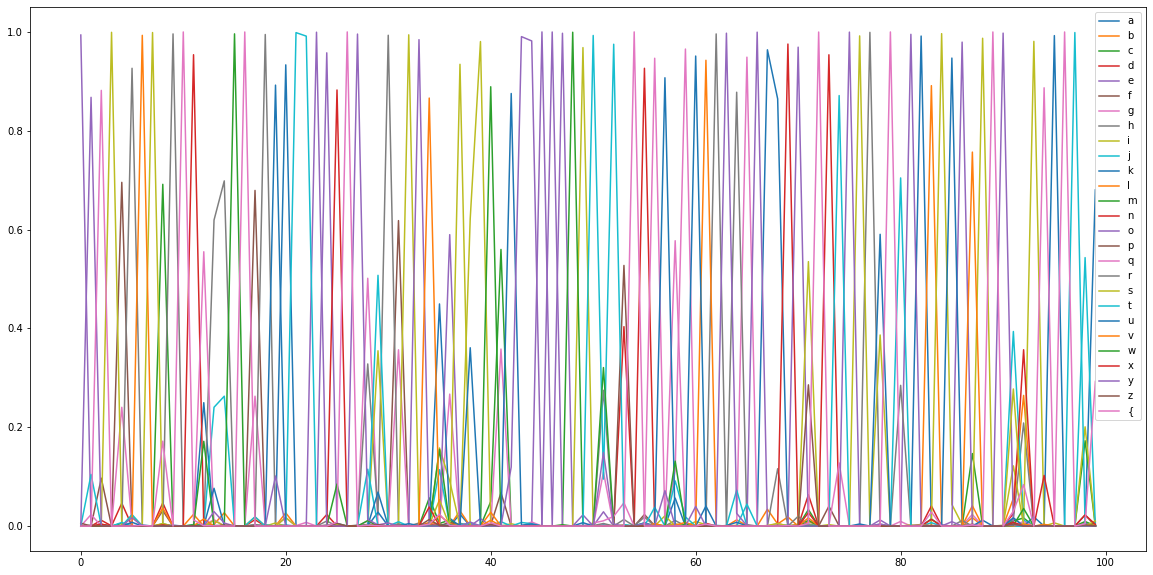

In [ ]:
print(predicted_classes_vgg.shape)
probs = np.transpose(predicted_classes_vgg)
print(probs.shape)

plt.figure(1, figsize=(20,10))
for num, i in enumerate(probs):
  plt.plot(np.arange(100), i, label = chr(num+97))

plt.legend()
plt.show()

####Save the model


In [ ]:
vgg16_model.save('/content/drive/MyDrive/Technion/vgg_model_BasicAugmentations')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Technion/vgg_model/assets


In [ ]:
!ls '/content/drive/MyDrive/Technion/vgg_model'

assets	keras_metadata.pb  saved_model.pb  variables


In [ ]:
reconstructed_model = keras.models.load_model('/content/drive/MyDrive/Technion/vgg_model')

In [ ]:
#make predictions with teh reconstucted model

predicted_classes_vgg = reconstructed_model.predict(rgb_X_test)
predicted_class_vgg = np.argmax(np.round(predicted_classes_vgg),axis=1)

#prob = reconstructed_model.predict_proba(rgb_X_test, batch_size=1, verbose=0)
#print(prob.shape)
#print(prob[0])
#print(np.argmax(prob[0]))
#print(Y_test[0])

#plt.imshow((X_test[1].squeeze()), interpolation='nearest', cmap='gray', vmin=0, vmax=1) #show images in gray
#plt.show()
#print(Y_test[1])

#print percent correct
results = predicted_class_vgg == [np.argmax(i) for i in Y_test]
print('{} / {} were correctly classified, {}%'.format(sum(results), len(results), sum(results)*100/ len(results) ))

757 / 800 were correctly classified, 94.625%
